In [1]:
workers = 2
batch_size=50
nz = 100
nch_g = 128
nch_d = 128
n_epoch = 20
lr = 0.0002
beta1 = 0.5
outf = './result-DCGAN'
display_interval = 600

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 256
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = MNIST("MNIST",train=True, download=True, transform=transform)

dataloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

cuda:0



Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw




Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw




Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw




Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
class Generator(nn.Module):
    def __init__(self, nz=100, nch_g=128, nch=1):
        super().__init__()
        self.layers = nn.Sequential(
                nn.ConvTranspose2d(nz, nch_g * 4, 3, 1, 0),     
                nn.BatchNorm2d(nch_g * 4),                     
                nn.ReLU(),                          
                nn.ConvTranspose2d(nch_g * 4, nch_g * 2, 3, 2, 0),
                nn.BatchNorm2d(nch_g * 2),
                nn.ReLU(),
                nn.ConvTranspose2d(nch_g * 2, nch_g, 4, 2, 1),
                nn.BatchNorm2d(nch_g),
                nn.ReLU(),
                nn.ConvTranspose2d(nch_g, nch, 4, 2, 1),
                nn.Tanh()
        )

    def forward(self, z):
        return self.layers(z)
    
    
class Discriminator(nn.Module):
    def __init__(self, nch=1, nch_d=128):
        """
        :param nch: 入力画像のチャネル数
        :param nch_d: 先頭層の出力チャネル数
        """
        super().__init__()
        self.layers = nn.Sequential(
                nn.Conv2d(nch, nch_d, 4, 2, 1),   
                nn.LeakyReLU(negative_slope=0.2),
            # (B, nch, 28, 28) -> (B, nch_d, 14, 14)
                nn.Conv2d(nch_d, nch_d * 2, 4, 2, 1),
                nn.BatchNorm2d(nch_d * 2),
                nn.LeakyReLU(negative_slope=0.2),
            # (B, nch_d, 14, 14) -> (B, nch_d*2, 7, 7)
                nn.Conv2d(nch_d * 2, nch_d * 4, 3, 2, 0),
                nn.BatchNorm2d(nch_d * 4),
                nn.LeakyReLU(negative_slope=0.2),
                nn.Conv2d(nch_d * 4, 1, 3, 1, 0),
                nn.Sigmoid()
            # (B, nch_d*4, 3, 3) -> (B, 1, 1, 1)
        )

    def forward(self, x):
        """
        順方向の演算
        :param x: 本物画像あるいは生成画像
        :return: 識別信号
        """
        x = self.layers(x)
        return x.squeeze()     # Tensorの形状を(B)に変更して戻り値とする
    
def weights_init(m):
    """
    ニューラルネットワークの重みを初期化する。作成したインスタンスに対しapplyメソッドで適用する
    :param m: ニューラルネットワークを構成する層
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:            # 畳み込み層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:     # バッチノーマライゼーションの場合
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [4]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

netG = Generator(nz=nz, nch_g=nch_g).to(device)
netG.apply(weights_init) 
netD = Discriminator(nch_d=nch_d).to(device)
netD.apply(weights_init)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [5]:
G_losses = []
D_losses = []
D_x_out = []
D_G_z1_out = []

# 学習のループ
for epoch in range(n_epoch):
    for itr, data in enumerate(dataloader):
        real_image = data[0].to(device)     # 本物画像
        sample_size = real_image.size(0)    # 画像枚数
        
        # 標準正規分布からノイズを生成
        noise = torch.randn(sample_size, nz, 1, 1, device=device)
        # 本物画像に対する識別信号の目標値「1」
        real_target = torch.full((sample_size,), 1., device=device)
        # 生成画像に対する識別信号の目標値「0」
        fake_target = torch.full((sample_size,), 0., device=device) 
        
        ############################
        # 識別器Dの更新
        ###########################
        netD.zero_grad()    # 勾配の初期化

        output = netD(real_image)   # 識別器Dで本物画像に対する識別信号を出力
        errD_real = criterion(output, real_target)  # 本物画像に対する識別信号の損失値
        D_x = output.mean().item()  # 本物画像の識別信号の平均

        fake_image = netG(noise)    # 生成器Gでノイズから生成画像を生成
        
        output = netD(fake_image.detach())  # 識別器Dで本物画像に対する識別信号を出力
        errD_fake = criterion(output, fake_target)  # 生成画像に対する識別信号の損失値
        D_G_z1 = output.mean().item()  # 生成画像の識別信号の平均

        errD = errD_real + errD_fake    # 識別器Dの全体の損失
        errD.backward()    # 誤差逆伝播
        optimizerD.step()   # Dのパラメーターを更新

        ############################
        # 生成器Gの更新
        ###########################
        netG.zero_grad()    # 勾配の初期化
        
        output = netD(fake_image)   # 更新した識別器Dで改めて生成画像に対する識別信号を出力
        errG = criterion(output, real_target)   # 生成器Gの損失値。Dに生成画像を本物画像と誤認させたいため目標値は「1」
        errG.backward()     # 誤差逆伝播
        D_G_z2 = output.mean().item()  # 更新した識別器Dによる生成画像の識別信号の平均

        optimizerG.step()   # Gのパラメータを更新

        if itr % display_interval == 0: 
            print('[{}/{}][{}/{}] Loss_D: {:.3f} Loss_G: {:.3f} D(x): {:.3f} D(G(z)): {:.3f}/{:.3f}'
                  .format(epoch + 1, n_epoch,
                          itr + 1, len(dataloader),
                          errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        if epoch == 0 and itr == 0:     # 初回に本物画像を保存する
            vutils.save_image(real_image, '{}/real_samples.png'.format(outf),
                              normalize=True, nrow=10)

        # ログ出力用データの保存
        D_losses.append(errD.item())
        G_losses.append(errG.item())
        D_x_out.append(D_x)
        D_G_z1_out.append(D_G_z1)

    ############################
    # 確認用画像の生成
    ############################
    fake_image = netG(fixed_noise)  # 1エポック終了ごとに確認用の生成画像を生成する
    vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(outf, epoch + 1),
                      normalize=True, nrow=10)


[1/20][1/235] Loss_D: 1.693 Loss_G: 3.135 D(x): 0.588 D(G(z)): 0.615/0.059
[2/20][1/235] Loss_D: 0.441 Loss_G: 4.197 D(x): 0.850 D(G(z)): 0.216/0.021
[3/20][1/235] Loss_D: 0.329 Loss_G: 2.086 D(x): 0.795 D(G(z)): 0.076/0.160
[4/20][1/235] Loss_D: 0.476 Loss_G: 2.500 D(x): 0.834 D(G(z)): 0.227/0.108
[5/20][1/235] Loss_D: 0.452 Loss_G: 2.313 D(x): 0.842 D(G(z)): 0.223/0.121
[6/20][1/235] Loss_D: 0.483 Loss_G: 1.600 D(x): 0.777 D(G(z)): 0.163/0.241
[7/20][1/235] Loss_D: 0.670 Loss_G: 2.042 D(x): 0.806 D(G(z)): 0.330/0.161
[8/20][1/235] Loss_D: 0.523 Loss_G: 3.275 D(x): 0.918 D(G(z)): 0.326/0.051
[9/20][1/235] Loss_D: 0.503 Loss_G: 2.476 D(x): 0.811 D(G(z)): 0.227/0.111
[10/20][1/235] Loss_D: 0.512 Loss_G: 1.929 D(x): 0.801 D(G(z)): 0.218/0.181
[11/20][1/235] Loss_D: 0.469 Loss_G: 3.283 D(x): 0.896 D(G(z)): 0.274/0.055
[12/20][1/235] Loss_D: 0.702 Loss_G: 2.306 D(x): 0.700 D(G(z)): 0.232/0.135
[13/20][1/235] Loss_D: 0.547 Loss_G: 2.112 D(x): 0.789 D(G(z)): 0.232/0.158
[14/20][1/235] Loss_D

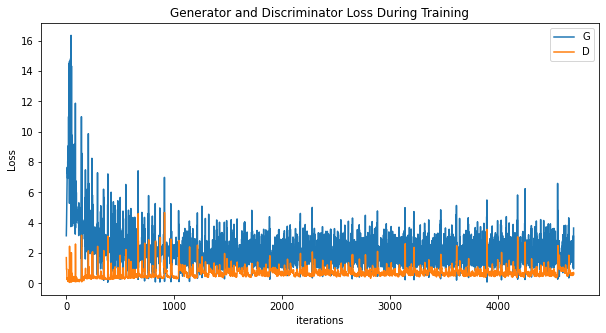

In [6]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()